# MIS373 - AI For Business - Assignment 2

## Task 1: House Price Prediction

**Student Name:** _Mason Nguyen_

**Student ID:** _222500596_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [AI Model Development](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

**Executive Problem Statement:**

The task was to develop and compare AI models, including linear regression and neural networks, to predict house prices based on housing features in a dataset containing approximately 20,000 house sales in Washington, USA. The goal was to identify the model with the best performance, justify its superiority, and evaluate its suitability for real-world deployment.

**Executive Solution Statement:**

- Data Preprocessing: Using a 70/30 split for training and testing sets with a fixed seed value

- AI Model Developement: Evaluating five predictive models, including two Neural Network Models,  Linear Regression Model, GRU Model, and LSTM Model.

- Report: The MLP Model 2 outperformed others across all key metrics: Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and Correlation Coefficient. Its accuracy, minimal error, and robust linear correlation position it as a reliable model to make decisions within the estate industry.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

1. Importing the dataset from Google Drive into Google Colab

2. No missing values were found in the dataset

3. 'date' column was converted back to date data type, and 'year' and 'quarter' columns were created from it before removing the 'date' column

4. 'id' column was removed as it lacks predictive power for price

5. 'zipcode' values were converted to categorical data, dummy variables were created, and one dummy variable was removed to prevent multicollinearity. Specifically, the dummy variable with the highest count was excluded

6. A function plot_hist() was defined for creating Line Charts in the analysis section

7. Split the preprocessed dataset into training and validation sets using a 70:30 ratio.

In [ ]:
from __future__ import print_function
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LSTM, Dense, GRU
import tensorflow as tf
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/dataset/Part1_house_price.csv"
house_price = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Finding column types
house_price.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [ ]:
# Convert the 'Date' column to datetime format
house_price['date'] = pd.to_datetime(house_price['date'], format='%Y%m%dT%H%M%S')

# Extract year and quarter from the 'Date' column and add them as new columns
house_price['year'] = house_price['date'].dt.year
house_price['quarter'] = house_price['date'].dt.quarter

In [ ]:
missing = house_price.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
quarter          0
dtype: int64

In [ ]:
house_price.drop(['id','date'], axis=1, inplace=True)
label_col = 'price'
house_price.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,quarter
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,4
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,4
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,1
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,4
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,1


In [ ]:
# Identify the zipcode with the highest count
most_common_zipcode = house_price['zipcode'].value_counts().idxmax()

# Create dummy variables
house_price_zip = pd.get_dummies(house_price['zipcode'], prefix='zc')

# Drop the column corresponding to the most common zipcode
house_price_zip = house_price_zip.drop('zc_' + str(most_common_zipcode), axis=1)

# Concatenate the dummy variables with the other numerical columns
house_price_num = house_price.select_dtypes(include='number')
house_price = pd.concat([house_price_num, house_price_zip], axis=1, join='inner')

In [ ]:
# Set a seed value
seed_value = 1234
# Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
train_size, valid_size, test_size = (0.7, 0.3, 0.0)
house_price_train, house_price_valid = train_test_split(house_price,
                                      test_size=valid_size,
                                      random_state=2020)

In [ ]:
house_price_y_train = house_price_train[[label_col]]
house_price_x_train = house_price_train.drop(label_col, axis=1)
house_price_y_valid = house_price_valid[[label_col]]
house_price_x_valid = house_price_valid.drop(label_col, axis=1)

print('Size of training set: ', len(house_price_x_train))
print('Size of validation set: ', len(house_price_x_valid))

Size of training set:  14000
Size of validation set:  6000


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(house_price_x_train)
house_price_x_train = pd.DataFrame(scaler.transform(house_price_x_train),
                            columns = house_price_x_train.columns, index = house_price_x_train.index)
house_price_x_valid = pd.DataFrame(scaler.transform(house_price_x_valid),
                            columns = house_price_x_valid.columns, index = house_price_x_valid.index)

print('X train min =', round(house_price_x_train.min().min(),4), '; max =', round(house_price_x_train.max().max(), 4))
print('X valid min =', round(house_price_x_valid.min().min(),4), '; max =', round(house_price_x_valid.max().max(), 4))

X train min = 0.0 ; max = 1.0
X valid min = 0.0 ; max = 2.0487


<a id = "cell_model"></a>
## 3. AI Model Development


1. Feature Scaling: Used the MinMaxScaler from scikit-learn to scale the features in the training and validation sets to a range of 0 to 1.

2. Model Architecture: MLP Model 2

- Input layer with the same size as the feature vector
- Dense layer with 100 nodes and tanh activation
- Dropout layer with a rate of 0.2 to prevent overfitting
- Dense layer with 180 nodes and ReLU activation
- Dense layer with 20 nodes and ReLU activation
- Output dense layer with a single node. The model is compiled with mean squared error loss, RMSprop optimizer with a learning rate of 0.005, and mean absolute error as a metric.


3. Early Stopping: To prevent overfitting, I implemented early stopping by monitoring the validation loss. If the validation loss does not improve for 10 consecutive epochs, the training will stop.

4. Model Training: Trained the model for a maximum of 100 epochs with a batch size of 64, using the training data and validation data. The training process is monitored using the EarlyStopping callback.

5. Model Evaluation: Evaluated the model's performance by calculating metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Correlation Coefficient between true and predicted values

9. Visualizations: Plotted the true vs. predicted values on the validation. I also plotted the training and validation loss and MAE over the epochs to understand the model's convergence behavior.


In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

**MLP Model**

In [ ]:
arr_x_train = np.array(house_price_x_train)
arr_y_train = np.array(house_price_y_train)
arr_x_valid = np.array(house_price_x_valid)
arr_y_valid = np.array(house_price_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (14000, 89)
Training samples:  14000
Validation samples:  6000


***

In [ ]:
# Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(180, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=RMSprop(learning_rate=0.005, rho=0.9, momentum=0.0, epsilon=1e-07, weight_decay=0.0,),
        metrics=[metrics.mae])
    return(t_model)

In [ ]:
model_b = basic_model_2(arr_x_train.shape[1], arr_y_train.shape[1])
model_b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               9000      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 180)               18180     
                                                                 
 dense_2 (Dense)             (None, 20)                3620      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 30821 (120.39 KB)
Trainable params: 30821 (120.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_b.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),callbacks=[early_stopping])

Epoch 1/500
219/219 - 8s - loss: 329001697280.0000 - mean_absolute_error: 430302.0312 - val_loss: 158986797056.0000 - val_mean_absolute_error: 236336.2500 - 8s/epoch - 35ms/step
Epoch 2/500
219/219 - 1s - loss: 114516713472.0000 - mean_absolute_error: 188509.5938 - val_loss: 66771861504.0000 - val_mean_absolute_error: 136187.4688 - 745ms/epoch - 3ms/step
Epoch 3/500
219/219 - 1s - loss: 63286411264.0000 - mean_absolute_error: 131158.6406 - val_loss: 45718413312.0000 - val_mean_absolute_error: 108296.0234 - 887ms/epoch - 4ms/step
Epoch 4/500
219/219 - 1s - loss: 47313043456.0000 - mean_absolute_error: 116824.5000 - val_loss: 34441039872.0000 - val_mean_absolute_error: 98448.8750 - 884ms/epoch - 4ms/step
Epoch 5/500
219/219 - 1s - loss: 39288737792.0000 - mean_absolute_error: 113013.0625 - val_loss: 29403531264.0000 - val_mean_absolute_error: 93920.8516 - 719ms/epoch - 3ms/step
Epoch 6/500
219/219 - 1s - loss: 35679830016.0000 - mean_absolute_error: 112078.1328 - val_loss: 26655803392.00

In [ ]:
train_score = model_b.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model_b.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 2), ', Train Loss: ', round(train_score[0], 2))
print('Val MAE: ', round(valid_score[1], 2), ', Val Loss: ', round(valid_score[0], 2))

Train MAE:  68729.63 , Train Loss:  14236404736.0
Val MAE:  69593.62 , Val Loss:  14581342208.0


In [ ]:
# After training the model and making predictions
y_pred2 = model_b.predict(arr_x_valid)

# Calculate Mean Squared Error
mse2 = mean_squared_error(arr_y_valid, y_pred2)
print('Mean Squared Error:', mse2)

# Calculate Root Mean Squared Error
rmse2 = np.sqrt(mse2)
print('Root Mean Squared Error:', rmse2)

# Calculate Mean Absolute Error
mae2 = mean_absolute_error(arr_y_valid, y_pred2)
print('Mean Absolute Error:', mae2)

# Calculate Correlation Coefficient
corrcoef2 = np.corrcoef(arr_y_valid.flatten(), y_pred2.flatten())
print('Correlation coefficient:', corrcoef2[0, 1])

188/188 [==============================] - 0s 2ms/step
Mean Squared Error: 14581346004.956188
Root Mean Squared Error: 120753.2442833574
Mean Absolute Error: 69593.59627864584
Correlation coefficient: 0.9461359920052698


188/188 [==============================] - 1s 3ms/step


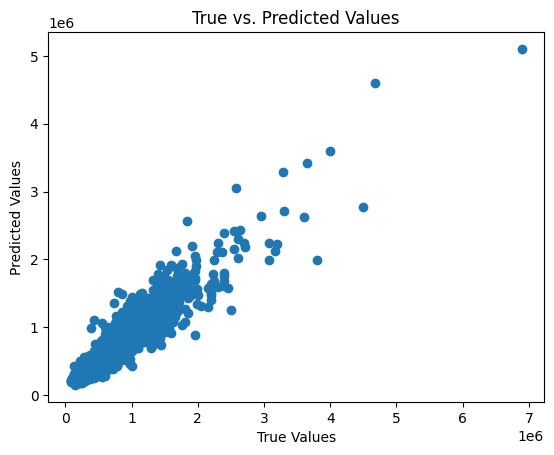

The Correlation between true and predicted values is: 0.946


In [ ]:
# Predict on validation data
y_valid_predict = model_b.predict(arr_x_valid)

# Plot true vs. predicted values
plt.scatter(arr_y_valid, y_valid_predict)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

# Calculate correlation coefficient without reshaping
corr_result = np.corrcoef(arr_y_valid.flatten(), y_valid_predict.flatten())

# Print correlation coefficient
print('The Correlation between true and predicted values is:', round(corr_result[0, 1], 3))

In [ ]:

 def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

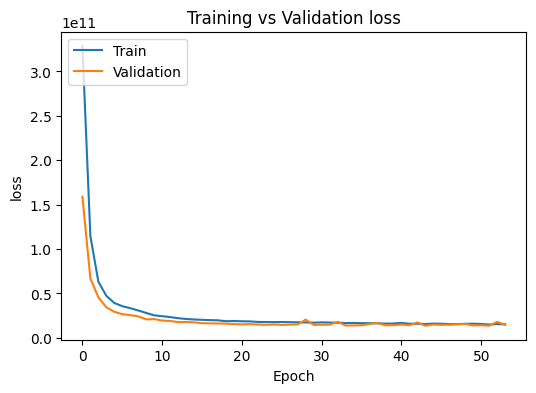

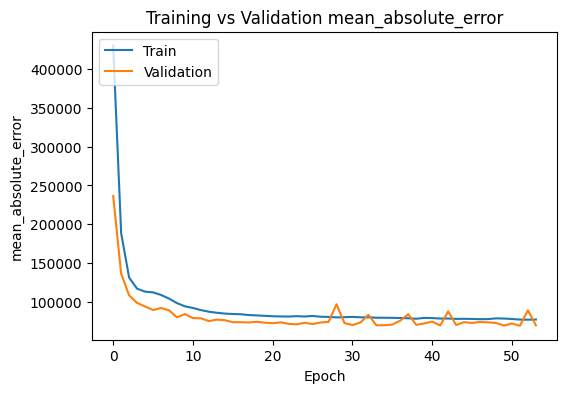

In [ ]:
hist = pd.DataFrame(history.history)

# Plot history
plot_hist(hist, xsize=6, ysize=4)

<a id = "cell_report"></a>
## 4. Experiments Report

**Task 1 – House Price Prediction**

In **Task 1** with the house price prediction dataset, **MLP Model 2** outperformed **MLP 1**, **Linear regression model**, **GPU Model** and **LSTM Model**  across all metrics:


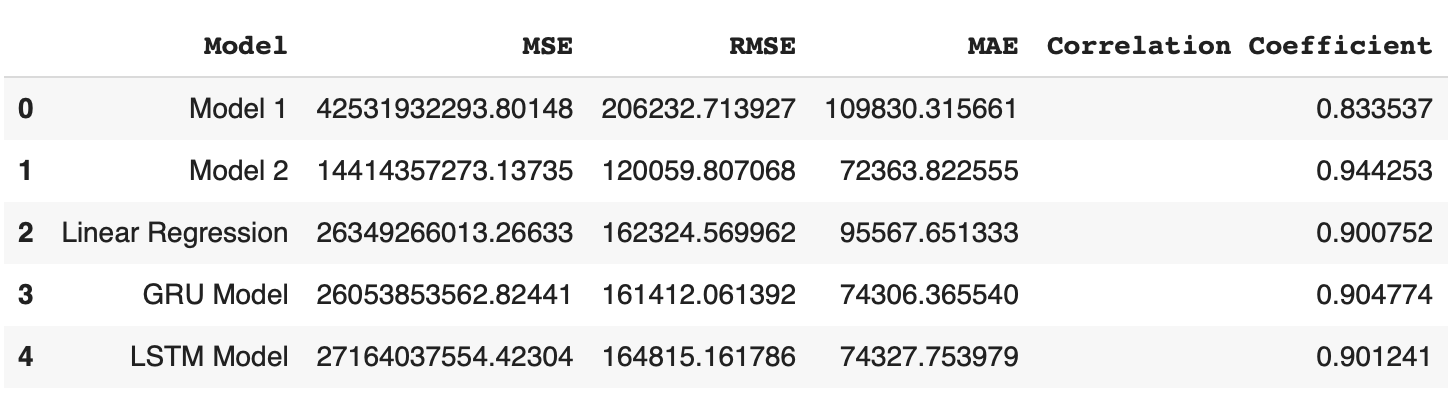

***Table 1: Models Comparison***

**1. Model MLP 1**:
- Input layer with the same size as the feature vector
- Dense layer with 100 nodes and ReLU activation
- Dense layer with y_size
- Output dense layer with a single node. The model is compiled with mean squared error loss, RMSprop optimizer with a learning rate of 0.001, and mean absolute error as a metric.

**2. Model MLP 2**:
- Input layer with the same size as the feature vector
- Dense layer with 100 nodes and tanh activation
- Dropout layer with a rate of 0.2 to prevent overfitting
- Dense layer with 180 nodes and ReLU activation
- Dense layer with 20 nodes and ReLU activation
- Output dense layer with a single node. The model is compiled with mean squared error loss, RMSprop optimizer with a learning rate of 0.005, and mean absolute error as a metric.

**3. Linear Regression Model**:
- A simple and interpretable model that assumes a linear relationship between the input features and the target variable. It help finding the best-fitting straight line that minimizes the sum of squared errors between the predicted and actual values.

**4. Model GRU**:
- GRU layer with 50 units and ReLU activation, dense of 1
- Output dense layer with a single node. The model is compiled with the Adam optimizer and mean squared error loss.

**5. Model LSTM**:
- LSTM layer with 50 units and ReLU activation, dense of 1
- Output dense layer with a single node. The model is compiled with the Adam optimizer and mean squared error loss.


**The MLP Model 2** demonstrated superior predictive accuracy with a lower **Mean Squared Error** at 14414357273.13735, indicating its predictions were closer to actual house prices. The **Root Mean Squared Error** of 120059.807068 interpretes for the model's accuracy. The **Mean Absolute Error** of 72363.822555 highlights the model's ability to make predictions within a reasonable range of the actual prices, without being influenced by outliers. Furthermore, the model's **Correlation Coefficient** of 0.944 suggests a stronger linear relationship between its predictions and the true house prices.

**Conclusion:** The MLP Model 2 performance using this dataset across all metrics makes it a suitable model for deployment in real-world house price prediction applications. Its higher accuracy, greater explained variance, and stronger linear correlation to true prices indicate a reliable model for price predictions.
